In [1]:
from Ranking import Ranking
import random
import numpy as np

seed = 12345
random.seed(seed)
np.random.seed(seed)

In [2]:
# Przy pierwszym czytaniu model musi z  pliku sessions.jsonl obliczyć wskaźnik populaności.
# Wtedy trzeba dać path = {path_to_jsonl_file}
#            ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓
r = Ranking(from_csv="sessions_popularity.csv", weeks=3, limit=0.25)

r.group_by_weeks()  # bierze ramke czasową o szerokości 3 tygodnie i przesuwa do przodu o tydzień. W każdej iteracji wylicza popularność
                    # dla każdego track_id jakie występuje.

100%|██████████| 52/52 [00:01<00:00, 39.21it/s]


In [3]:
r.add_new([
    {"session_id": 272299, "timestamp": "2024-05-20T06:36:16", "user_id": 523, "track_id": "1rAPOKdbcenPjBnDjqZu9Z", "event_type": "play"},
    {"session_id": 272291, "timestamp": "2024-05-20T06:47:06", "user_id": 661, "track_id": "2PLo8T3kGE9URFvBy3tUdt", "event_type": "play"},
    {"session_id": 272301, "timestamp": "2024-05-20T02:19:02", "user_id": 856, "track_id": "3pU1CUgPiFfxPCpscwIwQR", "event_type": "play"},
    {"session_id": 272307, "timestamp": "2024-05-20T00:42:54", "user_id": 941, "track_id": "6S6HSSk9HzWe3pqvUJn6Vq", "event_type": "play"},
    {"session_id": 272311, "timestamp": "2024-05-20T07:11:45", "user_id": 522, "track_id": "6ihwy1c6tsMC6AWANIrhH2", "event_type": "play"}
])

4it [00:00, 1497.30it/s]


100%|██████████| 52/52 [00:01<00:00, 40.17it/s]


In [10]:
r._get_first_week()
r.get_frame((2023, 40))

,track_id
4090,3z96E6DaTMAgj8QXOhK26A
3923,3p6hnejEQYXkiTO1lAzVc0
7421,7GAfYSIsC82zKw3TlieI5C
3759,3fuOCQmoOgNVq8fRW37iK0
6288,65vU70CBDU0sQDfOWkwUEH
...,...
4611,4Vc3bzFxXdrABa2DxgyCMT
5627,5T7ZFtCcOgkpjxcuaeZbw0
5682,5WitNasXEIRptoLIQUcXMx
4558,4SRYGZsbHrmH7E9xMVz4Wm


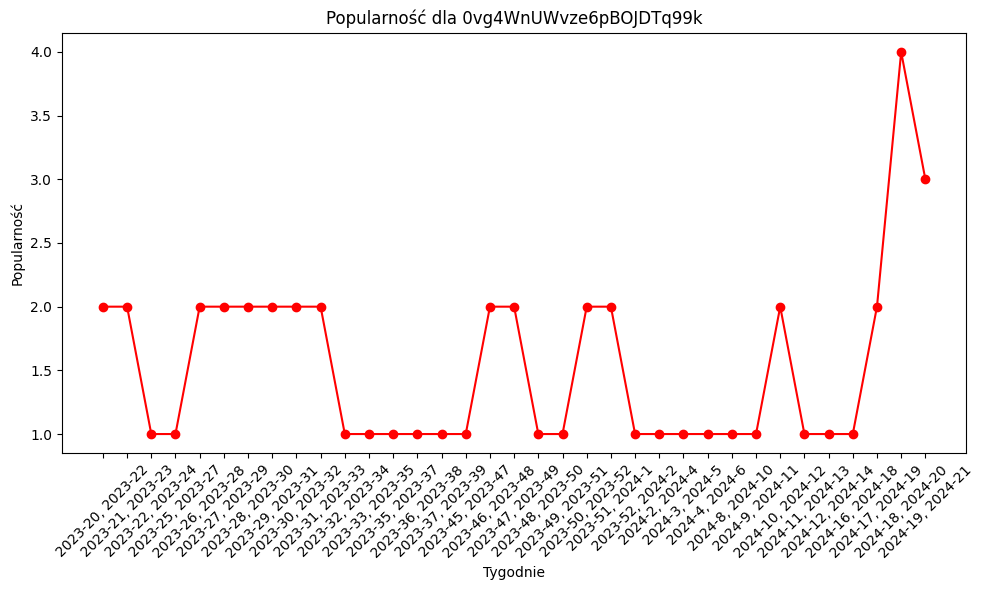

In [3]:
track = r.sessions_popularity.sample(1)
track_id = track.iloc[0]["track_id"]
r.make_plot(track_id)

Na przykładowym powyższym wykresie widać zmieniającą się popularność losowo wybranego utworu w kolejnych przedziałach czasowych. Oś x reprezentuje przedziały od rok-tydzień do rok-tydzień jako 1 argument. W modelu powyżej wzięte zostały przedziały 3-tygodniowe.


### Model bazowy

Model bazowy dla danego okresu nie wybiera utworów, które są najbardziej popularne (wedlug wyliczonego wskaźnika popularity) tylko bierze losowo zwraca id utworów z tego okresu i je proponuje na następny tydzień nie wiedząc czy faktycznie tam te utwory się pojawią czy nie. 


### Model docelowy

Model docelowy będzie zwracał z danego okresu czasu, część utworów o najwyższej wartości popularności.


#### Porównanie modeli

Porównanie modeli polega na sprawdzeniu ile zwróconych przez nich id_utworów faktycznie pojawi się następnym tygodniu (na podstawie sesji z przeszłości).
Założenia są takie, że oba modele zwracają taką samą ilość utworów (Jest to ograniczone przez hiperparametr limit w modelu).

Innymi słowy załóżmy, że chcemy sprawdzić czy model rozszerzony jest lepszy dla tygodni 40-42 w roku 2023r. Nasz hiperparametr weeks wynosi 3 co oznacza, że model generuje ramki czasowe o długości 3 tygodni. W tym przypadku sprawdzimy ramke od 2023r i 40 tygodnia do 2023r i 42 tydzień. Z tego przedziału oba modele wygenerują ranking na przyszły tydzień, czyli 2023r i 43 tydzień. Z tym, że model podstawowy wygeneruje tą liste w sposób losowy, zaś model docelowy wyliczy sobie współczynnik popularności dla utworów w tym okresie i wybierze te najlepiej ocenianie. Hiperparametr limit steruje ile chcemy zwracać utworów z danego okresu. W tym przypadku wynis 0.25, czyli zwróci 25% wszystkich utworów pojawiających się w danym okresie.

Poniżej sprawdzamy dla danych z sesji dotyczących przeszłości dla 50 różnych ziarn generatora. Dla każdego pojedyńczego ziarna jest wykonywany test dla wszystkich ramek w okresie 2023r 20 tydzień do 2024r 21 tydzień, gdzie każda ramka ma długość 3 tygodni.

In [6]:
for i in range(1, 51):
    # ustawianie ziarna generatora
    random.seed(seed + i)
    np.random.seed(i)
    result = r.compare_to_basic()
    model = 'podstawowy'
    if result['basic'] < result['extended']:
        model = 'rozszerzony'
    print(f"{i}: Lepszy jest {model}. ({result['basic']} : {result['extended']})")
    

1: Lepszy jest rozszerzony. (3 : 49)
2: Lepszy jest rozszerzony. (3 : 49)
3: Lepszy jest rozszerzony. (4 : 48)
4: Lepszy jest rozszerzony. (3 : 49)
5: Lepszy jest rozszerzony. (1 : 51)
6: Lepszy jest rozszerzony. (1 : 51)
7: Lepszy jest rozszerzony. (3 : 49)
8: Lepszy jest rozszerzony. (2 : 50)
9: Lepszy jest rozszerzony. (1 : 51)
10: Lepszy jest rozszerzony. (3 : 49)
11: Lepszy jest rozszerzony. (3 : 49)
12: Lepszy jest rozszerzony. (5 : 47)
13: Lepszy jest rozszerzony. (4 : 48)
14: Lepszy jest rozszerzony. (3 : 49)
15: Lepszy jest rozszerzony. (1 : 51)
16: Lepszy jest rozszerzony. (5 : 47)
17: Lepszy jest rozszerzony. (3 : 49)
18: Lepszy jest rozszerzony. (4 : 48)
19: Lepszy jest rozszerzony. (2 : 50)
20: Lepszy jest rozszerzony. (2 : 50)
21: Lepszy jest rozszerzony. (4 : 48)
22: Lepszy jest rozszerzony. (5 : 47)
23: Lepszy jest rozszerzony. (4 : 48)
24: Lepszy jest rozszerzony. (4 : 48)
25: Lepszy jest rozszerzony. (2 : 50)
26: Lepszy jest rozszerzony. (3 : 49)
27: Lepszy jest rozsz

Z powyższych wyników widać, że model docelowy dla każdego z ziaren generatora wybiera trafniej utwory i działa lepiej niż losowo działający model, co oznacza że analityczne kryterium sukcesu zostało spełnione.

In [4]:
r.make_test_for_every_frame()

100%|██████████| 51/51 [00:00<00:00, 97.03it/s] 

Ranking z tygodni: (2023, 20)-(2023, 22). Ilość trafień % w tygodniu (2023, 23): 17.165%
Ranking z tygodni: (2023, 21)-(2023, 23). Ilość trafień % w tygodniu (2023, 24): 14.733%
Ranking z tygodni: (2023, 22)-(2023, 24). Ilość trafień % w tygodniu (2023, 25): 17.004%
Ranking z tygodni: (2023, 23)-(2023, 25). Ilość trafień % w tygodniu (2023, 26): 21.19%
Ranking z tygodni: (2023, 24)-(2023, 26). Ilość trafień % w tygodniu (2023, 27): 24.09%
Ranking z tygodni: (2023, 25)-(2023, 27). Ilość trafień % w tygodniu (2023, 28): 23.45%
Ranking z tygodni: (2023, 26)-(2023, 28). Ilość trafień % w tygodniu (2023, 29): 17.89%
Ranking z tygodni: (2023, 27)-(2023, 29). Ilość trafień % w tygodniu (2023, 30): 20.56%
Ranking z tygodni: (2023, 28)-(2023, 30). Ilość trafień % w tygodniu (2023, 31): 19.037%
Ranking z tygodni: (2023, 29)-(2023, 31). Ilość trafień % w tygodniu (2023, 32): 18.194%
Ranking z tygodni: (2023, 30)-(2023, 32). Ilość trafień % w tygodniu (2023, 33): 22.321%
Ranking z tygodni: (2023, 

In [5]:
arr = []

for key, frame in r.sessions_popularity_per_weeks.items():
    arr.append(frame.shape[0])

array = np.array(arr)
print(round(array.mean(), 0))  # średnia ilość utworów

8569.0


Tak wyglądają wyniki dla modelu rozszerzonego. Co prawda nie są to duże wartości, ale z okresu 3 tygodni średnio pojawia się 8500 utworów różnych, a wzięcie 25% z nich daje ponad 2 tysiące. Więc jeśli trafność jest na poziomie 20% około to dalej 400 utworów, które zaproponowaliśmy zostało odtworzonych w następnym tygodniu. Jeśli użytkownicy faktycznie wybieraliby chętniej proponowane utwory z playlist to można założyć, że ilość trafień byłaby jeszcze większa. W tym momencie są to tylko dane z przeszłości czyli okresu kiedy użytkownicy nie mieli żadnych sugestii dotyczących utworów.